In [2]:
import numpy as np
from numpy import inf as inf
from scipy.stats import binom
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import timeit
from pyomo.environ import *
from pyomo.opt import SolverFactory
from random import shuffle
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
def connectGraph(graph):
    """
    Esta función se asegura que la matriz de adyacencia que entra por parámetro defina
    un grafo conexo, lo hace agregando un ciclo de tamaño N donde N es el número de nodos los nodos.
    Este ciclo pasa una sola vez por cada nodo. 
    @param graph: Matriz de adyacencia de un grafo conexo.
    """
    n = len(graph)
    nodes = list(range(n))
    shuffle(nodes)

    for i in range(n-1):

        actual, sig = nodes[i], nodes[i+1]
        graph[actual, sig] = 1

    graph[nodes[-1], nodes[0]] = 1



def generateRandomConnectedGraph(n, connectness: float = 0.2):
    """
    Esta función genera la matriz de adyacencia de un grafo dirigido, con pesos entre 1 y 50. 
    simplemente conexo y con N nodos.
    @param n: Número de nodos del grafo
    @param connectness: indica, en promedio, el porcentaje de vertices que llegarán y saldrán de un nodo. 
    El rango es entre 0 y 1.
    return: Matriz de adyacencia del grafo y la matriz de pesos
    """

    # Inicialización de los vertices del grafo. 
    adyacencia = np.double(binom.rvs(1, connectness, size=n*n).reshape((n, n)))
    # Nos aseguramos que sea conexo
    connectGraph(adyacencia)
    # Generamos los pesos
    pesos = np.multiply(adyacencia, np.random.randint(1, 51, (n, n)))
    # Si no hay conexión a un nodo el peso es infinito
    pesos[pesos == 0] = inf 

    return adyacencia, pesos


In [4]:
grafo, pesos = generateRandomConnectedGraph(10, connectness = 0.2)
print(pesos)

[[inf 39.  3. inf inf inf inf 39. inf inf]
 [18. inf inf inf inf  9. inf inf  4. 31.]
 [inf 10. inf inf 46. 16. 28. inf inf inf]
 [43. inf inf inf 50. 12.  2. inf inf inf]
 [inf inf inf inf inf inf inf 38. inf inf]
 [inf  5. inf inf 28. 38. inf inf inf inf]
 [inf 27. inf inf inf inf 14.  9. inf inf]
 [inf inf inf inf  1. inf 41. 46. 14. inf]
 [inf 46. inf inf inf inf 13. inf 14. 39.]
 [inf inf inf 22. inf inf inf inf inf inf]]


In [5]:
print(grafo)

[[0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [6]:
def execTime(func):
    """
    Definición de un decorador que se usa para retornar el tiempo 
    de ejecución de una función. 
    @param func. La función a la que se le medirá el tiempo de ejecución
    @return time, result. 
    time: Tiempo en segundos de la ejecución de la función.
    result: Resultado de la función. 
    """
    def wrapper(*args, **kwargs):
        init_time = timeit.default_timer()
        result = func(*args, **kwargs)
        stop_time = timeit.default_timer()
        total = stop_time - init_time
        return total, result
    return wrapper

In [7]:
def getPathToEnd(end, dijkstraPath):
    actual = int(end)
    path = []
    while actual != -1:
        path.append(actual)
        actual = int(dijkstraPath[actual])
    return path


@execTime
def dijkstra(pesos, init, end):
    """ 
    Implementación eficiente de Dijkstra usando priority queue con la librería
    de Python heapq (no hay que descargarla, hace parte del core de Python)
    @param pesos: Matriz de pesos de grafo dirigido. Solo positivos.
    @param init: Nodo de inicio del algoritmo. Debe estar entre 0 y len(pesos) - 1.
    """

    # Número de nodos
    n = len(pesos)

    # Inicialización de arreglos auxiliares y el vector respuesta (path)
    dist = np.ones(n) * inf
    visited = np.array([False for i in range(n)])
    path = np.ones(n) * -1

    dist[init] = 0
    visited[init] = True

    heap = []
    # Priority queue. Se ordena el heap basado en la primera entrada de la tupla 
    # (distancia, posicion) que se le pasa. Sacar el mínimo es O(1)
    heappush(heap, (dist[init], init))

    while len(heap) > 0:

        (minimo, nodoMin) = heappop(heap)
        nodoMin = int(nodoMin)
        visited[nodoMin] = True

        # Se recorren los nodos con pesos menores a infinito (los vecinos)
        for v in (v for v, peso in enumerate(pesos[nodoMin, :]) if peso < inf):
            if not visited[v]:
                # print('min: ',  nodoMin, 'v:', v, '-', dist[nodoMin], '-', pesos[nodoMin, v])

                # Si el nodo no ha sido visitado y la distancia desde el actual es menor
                # Entonces se actualiza su distancia
                if dist[v] > dist[nodoMin] + pesos[nodoMin, v]:

                    dist[v] = dist[nodoMin] + pesos[nodoMin, v]
                    path[v] = nodoMin
                    heappush(heap, (dist[v], v))

    pathToEnd = getPathToEnd(end, path)

    return path, pathToEnd


In [9]:
time, (path, pathToEnd) = dijkstra(pesos, 3, 4)
print('La función demoró:', time*1000, 'ms corriendo')
print(path)

La función demoró: 0.17079999997804407 ms corriendo
[ 1.  5.  0. -1.  7.  3.  3.  6.  1.  1.]


In [10]:
@execTime
def opti(pesos, init, fin):
    Model = ConcreteModel()

    # SETS & PARAMETERS********************************************************************
    numNodes = len(pesos)

    N = RangeSet(0, numNodes-1)

    cost = dict()
    for u in range(len(pesos)):
        for v in range(len(pesos[u])):
            if pesos[u][v] == inf:
                cost[u, v] = 999
            else:
                cost[u, v] = pesos[u][v]

    # print(cost)
    """
    cost={(1,1):999, (1,2):5,   (1,3):2,   (1,4):999, (1,5):999,\
          (2,1):999, (2,2):999, (2,3):999, (2,4):999, (2,5):8,\
          (3,1):999, (3,2):999, (3,3):999, (3,4):3,   (3,5):999,\
          (4,1):999, (4,2):999, (4,3):999, (4,4):999, (4,5):2,\
          (5,1):999, (5,2):999, (5,3):999, (5,4):999, (5,5):999}
    """

    # VARIABLES****************************************************************************
    Model.x = Var(N, N, domain=Binary)

    # OBJECTIVE FUNCTION*******************************************************************
    Model.obj = Objective(expr=sum(Model.x[i, j] * cost[i, j] for i in N for j in N))

    # CONSTRAINTS**************************************************************************
    def source_rule(Model, i):
        if i == init:
            return sum(Model.x[i, j] for j in N) == 1
        else:
            return Constraint.Skip

    Model.source = Constraint(N, rule=source_rule)

    def destination_rule(Model, j):
        if j == fin:
            return sum(Model.x[i, j] for i in N) == 1
        else:
            return Constraint.Skip

    Model.destination = Constraint(N, rule=destination_rule)

    def intermediate_rule(Model, i):
        if i != init and i != fin:
            return sum(Model.x[i, j] for j in N) - sum(Model.x[j, i] for j in N) == 0
        else:
            return Constraint.Skip

    Model.intermediate = Constraint(N, rule=intermediate_rule)

    # APPLYING THE SOLVER******************************************************************
    SolverFactory('glpk').solve(Model)

    # Model.display()
    
    return 0

In [11]:
def graphExecutionTimes(samples=50, maxNodes=200, connectness = 0.5):
    """
    Función principal que se encarga de graficar el tiempo de ejecución de Dijkstra y 
    optimización dado el crecimiento de los nodos.

    @param samples: Número de muestras de grafos que se generarán por cada incremento en el 
    número de nodos. Los resultados graficados será el promedio de estas muestras
    @param masNodes: Número máximo de nodos a evaluar. Se empieza con grafos de 5 nodos y aumenta
    progresivamente el número de nodos hasta este valor.
    @param connectness: Qué tan conectados van a estar los grafos creados. Toma un valor entre 0 y 1. 
    Que este en 0 no significa que el grafo no sea conexo, siempre nos aseguramos que cualquier grafo
    generado sea conexo. A grandes rasgos este número indica, para un nodo, el porcentaje del total de
    nodos conectados a él. 
    """

    dijkstraTimes = []
    optiTimes = []
    max_count = maxNodes - 6
    f = IntProgress(min=0, max=max_count)
    display(f)

    for n in range(5, maxNodes):
        f.value += 1 # signal to increment the progress bar

        sampleTimeDij = []
        sampleTimeOpti = []
        # print(n)

        for sample in range(samples):
            # Genera un grafo conexo de n nodos
            grafo, pesos = generateRandomConnectedGraph(n, connectness = connectness)
            startNode = np.random.randint(0, n)
            array = list((v for v in range(n) if v != startNode))
            # print(startNode, array)
            endNode = np.random.choice(array)

            # Primero con dijkstra
            nthTime, (path, pathToEnd) = dijkstra(pesos, startNode, endNode)
            sampleTimeDij.append(nthTime)

            # Ahora con optimización
            nthTime, zero = opti(pesos, startNode, endNode)
            sampleTimeOpti.append(nthTime)
        
        avgTime = sum(sampleTimeDij) / len(sampleTimeDij)
        dijkstraTimes.append(avgTime)
        
        avgTimeOpti = sum(sampleTimeOpti) / len(sampleTimeOpti)
        optiTimes.append(avgTimeOpti)
        
        # print(avgTime, avgTimeOpti)
    
    dijkstraTimes = np.array(dijkstraTimes)
    optiTimes = np.array(optiTimes)

    # Plot results
    E = lambda V: V*(V-1)*connectness #Número aproximado de vertices según el algoritmo de generación
    dijkComplFunc = lambda V: V + E(V)*np.log(V)

    # Factor de Reajuste del cálculo de complejidad (Empírico)
    C = min(np.array(dijkstraTimes[:5]))/80
    dijkCompl = np.array([dijkComplFunc(V) for V in range(5, maxNodes)]) * C

    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplot(3, 1, 1)

    plt.plot(list(range(5, maxNodes)), dijkstraTimes*1000, color='b', label='Tiempos usando Dijkstra')
    plt.plot(list(range(5, maxNodes)), optiTimes*1000, color='r', label='Tiempos usando Optimización')
    plt.plot(list(range(5, maxNodes)), 
            dijkCompl*1000, color='y', 
            label='Complejidad Teórica de Dijsktra O(V + E LogV)')
    plt.legend()
    plt.title('Comparación tiempos Dijsktra vs Optimización')
    plt.xlabel('Número de Nodos')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.grid(1)

    plt.subplot(3, 1, 2)
    plt.plot(list(range(5, maxNodes)), dijkstraTimes*1000, color='b', label='Tiempos usando Dijkstra')
    plt.plot(list(range(5, maxNodes)), 
            dijkCompl*1000, color='y', 
            label='Complejidad Teórica de Dijsktra O(V + E LogV)')
    plt.legend()
    plt.title('Comparación tiempo teórico Dijkstra vs Teórico.')
    plt.xlabel('Número de Nodos')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.grid(1)

    plt.subplot(3, 1, 3)
    plt.plot(list(range(5, maxNodes)), optiTimes*1000, color='r', label='Tiempos usando Optimización')
    plt.title('Tiempos de ejecución usando optimización.')
    plt.xlabel('Número de Nodos')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.grid(1)
    plt.tight_layout()
    plt.show()



IntProgress(value=0, max=194)

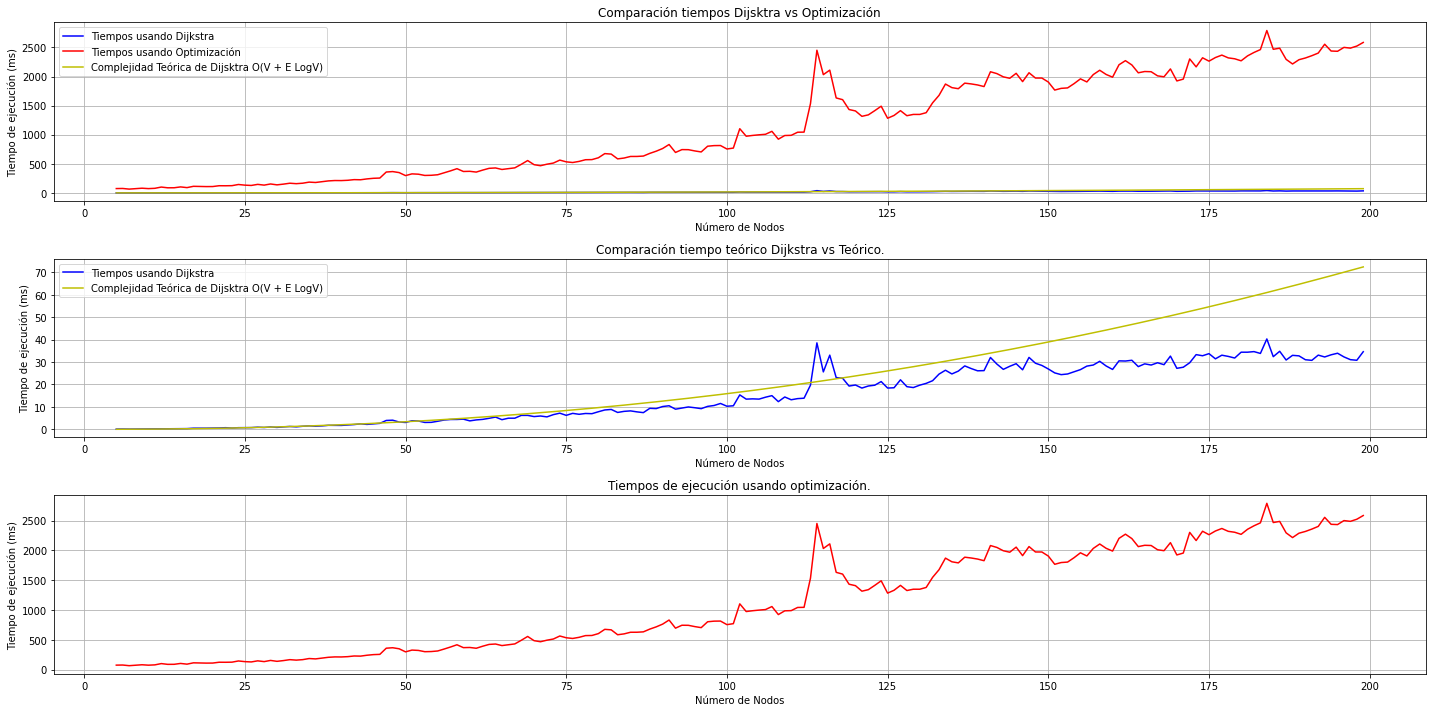

In [12]:
graphExecutionTimes(samples=20, maxNodes=200, connectness = 0.3)

In [62]:
grafoTest, pesosTest = generateRandomConnectedGraph(5, connectness = 0.1)
print(grafoTest)
print(pesosTest)

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
[[inf 29. inf inf inf]
 [inf inf 25. inf inf]
 [inf inf inf inf 29.]
 [18. inf 19. inf inf]
 [inf inf inf 28. inf]]
